# Hard Attention MNIST

This is jupyter notebook for `Hard Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

# TENSORFLOW 1

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform
import cv2
import os

/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print(tf.version.VERSION)

1.14.0


In [3]:
print(tf.test.is_gpu_available())

False


In [4]:
# Import MNIST data

mat_data_train = scipy.io.loadmat('../dataset/MNIST_mod/MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('../dataset/MNIST_mod/MNIST_data_test_re.mat')

train_x = mat_data_train['X_train']
train_y = mat_data_train['Y_train']

test_x = mat_data_test['X_test']#[:9900, :]
test_y = mat_data_test['Y_test']#[:9900, :]

# validation_x = mat_data_test['X_test'][9900:, :]
# validation_y = mat_data_test['Y_test'][9900:, :]

del mat_data_train
del mat_data_test

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
# print("Validation data shape: " + str(validation_x.shape))
# print("Validation label shape: " + str(validation_y.shape))
print(np.max(test_x), np.min(test_x))

Train data shape: (55000, 112, 112)
Train label shape: (55000, 10)
Test data shape: (10000, 112, 112)
Test label shape: (10000, 10)
1.0 0.0


## Parameters

In [5]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_path = 'saved_models/mod_hard/'
if not os.path.exists(save_path):
  os.makedirs(save_path)

# Numbers of sampling to test the code 
num_test_sample = 50

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

## Plotting Sample Image (Modified MNIST for Attention)

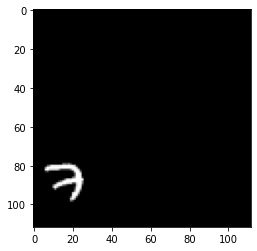

Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Shape: 112x112


In [6]:
# Plotting example image
img = train_x[0, :, :]

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img_size) + 'x' + str(img_size))

## Functions for Convolutional Network

In [7]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [8]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Hard Attention function
def hard_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)     
    alpha = tf.nn.softmax(m_concat) 
    
    #For Monte-Carlo Sampling
    alpha_cumsum = tf.cumsum(alpha, axis = 1)
    len_batch = tf.shape(alpha_cumsum)[0]
    rand_prob = tf.random_uniform(shape = [len_batch, 1], minval = 0., maxval = 1.)
    alpha_relu = tf.nn.relu(rand_prob - alpha_cumsum)
    alpha_index = tf.count_nonzero(alpha_relu, 1)
    alpha_hard  = tf.one_hot(alpha_index, len(a))

    z_list = [tf.multiply(a[i], tf.slice(alpha_hard, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    return alpha, z
    

## Network

In [9]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_size, img_size, 1])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, 1, 64])
b_conv1 = bias_variable('b_conv1', [64])
w_conv2 = weight_variable('W_conv2', [3, 3, 64, 256])
b_conv2 = bias_variable('b_conv2', [256])
w_conv3 = weight_variable('W_conv3', [3, 3, 256, 512])
b_conv3 = bias_variable('b_conv3', [512])

conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 2) + b_conv1)
conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 2) + b_conv2)
conv3 = tf.nn.relu(conv2d(conv2, w_conv3, 2) + b_conv3)

conv_size = conv3.get_shape()[1]
conv_flat = tf.reshape(conv3, [-1, conv_size*conv_size, 512])
conv_unstack = tf.unstack(conv_flat, axis = 1)

#LSTM Variables
Wf = weight_variable('Wf', [512 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [512 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [512 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [512 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [512, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = hard_attention(rnn_out, conv_unstack, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
reduction_indices is deprecated, use axis instead


In [10]:
# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create Session

In [11]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [12]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state(save_path)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [13]:
# Training
interval_test=num_epoch/2
if Is_train == True:
    train_data_num = train_x.shape[0]
    test_data_num = test_x.shape[0]
    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]

            # Make image as fractions for attention
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, 1))
#             validation_batch = np.reshape(validation_x, (validation_x.shape[0], img_size, img_size, 1))
            
            # Training
            optimizer.run(feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_batch, y_target: batch_y_train})
           # val_acc = sess.run(accuracy, feed_dict = {x_image: validation_batch, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc))# + ' / ' + 
#                   "Validation Accuracy: " + str(val_acc))  

        if (i+1)%interval_test==0:
            num_correct = 0
            saver.save(sess, save_path + "hard_attention")
            print('Model is saved!!!')

            print('Testing ...')
            idx = random.sample(range(test_x.shape[0]), test_data_num)
            for idx_sample in range(test_data_num):
                test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
                test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
                output_ = sess.run(output,feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
                
                y_test_pred = np.argmax(output_[:])
                y_test_true = np.argmax(test_y[idx[idx_sample], :])
                if y_test_pred == y_test_true:
                    num_correct += 1.
                
            # Print Progress
            print("Testing Accuracy: " + str(num_correct/test_data_num))# + ' / ' + )

Epoch: 1 / Batch: 0/55000 / Cost: 0.68547523 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 256/55000 / Cost: 0.63945556 / Training Accuracy: 0.09765625
Epoch: 1 / Batch: 512/55000 / Cost: 0.5833541 / Training Accuracy: 0.1328125
Epoch: 1 / Batch: 768/55000 / Cost: 0.51563877 / Training Accuracy: 0.1328125
Epoch: 1 / Batch: 1024/55000 / Cost: 0.44730195 / Training Accuracy: 0.11328125
Epoch: 1 / Batch: 1280/55000 / Cost: 0.38436848 / Training Accuracy: 0.11328125
Epoch: 1 / Batch: 1536/55000 / Cost: 0.35262638 / Training Accuracy: 0.0703125
Epoch: 1 / Batch: 1792/55000 / Cost: 0.3360876 / Training Accuracy: 0.07421875
Epoch: 1 / Batch: 2048/55000 / Cost: 0.33032197 / Training Accuracy: 0.10546875
Epoch: 1 / Batch: 2304/55000 / Cost: 0.34071192 / Training Accuracy: 0.11328125
Epoch: 1 / Batch: 2560/55000 / Cost: 0.3450961 / Training Accuracy: 0.08984375
Epoch: 1 / Batch: 2816/55000 / Cost: 0.34518138 / Training Accuracy: 0.11328125
Epoch: 1 / Batch: 3072/55000 / Cost: 0.3471757 / Train

Epoch: 1 / Batch: 26624/55000 / Cost: 0.3240467 / Training Accuracy: 0.1328125
Epoch: 1 / Batch: 26880/55000 / Cost: 0.3261098 / Training Accuracy: 0.08984375
Epoch: 1 / Batch: 27136/55000 / Cost: 0.32506675 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 27392/55000 / Cost: 0.32429105 / Training Accuracy: 0.1328125
Epoch: 1 / Batch: 27648/55000 / Cost: 0.32392514 / Training Accuracy: 0.13671875
Epoch: 1 / Batch: 27904/55000 / Cost: 0.32570252 / Training Accuracy: 0.09765625
Epoch: 1 / Batch: 28160/55000 / Cost: 0.3267014 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 28416/55000 / Cost: 0.32497364 / Training Accuracy: 0.10546875
Epoch: 1 / Batch: 28672/55000 / Cost: 0.32597128 / Training Accuracy: 0.09375
Epoch: 1 / Batch: 28928/55000 / Cost: 0.3253913 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 29184/55000 / Cost: 0.32433376 / Training Accuracy: 0.1328125
Epoch: 1 / Batch: 29440/55000 / Cost: 0.32591054 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 29696/55000 / Cost: 0.32472

Epoch: 1 / Batch: 52992/55000 / Cost: 0.324664 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 53248/55000 / Cost: 0.32572335 / Training Accuracy: 0.0859375
Epoch: 1 / Batch: 53504/55000 / Cost: 0.32646218 / Training Accuracy: 0.0859375
Epoch: 1 / Batch: 53760/55000 / Cost: 0.3254207 / Training Accuracy: 0.0859375
Epoch: 1 / Batch: 54016/55000 / Cost: 0.32474247 / Training Accuracy: 0.10546875
Epoch: 1 / Batch: 54272/55000 / Cost: 0.32582134 / Training Accuracy: 0.1171875
Epoch: 1 / Batch: 54528/55000 / Cost: 0.32466498 / Training Accuracy: 0.1484375
Epoch: 1 / Batch: 54784/55000 / Cost: 0.32595608 / Training Accuracy: 0.11111111
Epoch: 2 / Batch: 0/55000 / Cost: 0.32569736 / Training Accuracy: 0.09765625
Epoch: 2 / Batch: 256/55000 / Cost: 0.32481614 / Training Accuracy: 0.12109375
Epoch: 2 / Batch: 512/55000 / Cost: 0.32501864 / Training Accuracy: 0.12890625
Epoch: 2 / Batch: 768/55000 / Cost: 0.3250125 / Training Accuracy: 0.10546875
Epoch: 2 / Batch: 1024/55000 / Cost: 0.324804 / T

Epoch: 2 / Batch: 24576/55000 / Cost: 0.3262177 / Training Accuracy: 0.11328125
Epoch: 2 / Batch: 24832/55000 / Cost: 0.32612452 / Training Accuracy: 0.08203125
Epoch: 2 / Batch: 25088/55000 / Cost: 0.3259652 / Training Accuracy: 0.078125
Epoch: 2 / Batch: 25344/55000 / Cost: 0.32529047 / Training Accuracy: 0.078125
Epoch: 2 / Batch: 25600/55000 / Cost: 0.32532722 / Training Accuracy: 0.0625
Epoch: 2 / Batch: 25856/55000 / Cost: 0.32535946 / Training Accuracy: 0.08984375
Epoch: 2 / Batch: 26112/55000 / Cost: 0.3249332 / Training Accuracy: 0.1171875
Epoch: 2 / Batch: 26368/55000 / Cost: 0.324764 / Training Accuracy: 0.09765625
Epoch: 2 / Batch: 26624/55000 / Cost: 0.3248499 / Training Accuracy: 0.08984375
Epoch: 2 / Batch: 26880/55000 / Cost: 0.32562798 / Training Accuracy: 0.078125
Epoch: 2 / Batch: 27136/55000 / Cost: 0.32551342 / Training Accuracy: 0.10546875
Epoch: 2 / Batch: 27392/55000 / Cost: 0.3254803 / Training Accuracy: 0.078125
Epoch: 2 / Batch: 27648/55000 / Cost: 0.3248728 

Epoch: 2 / Batch: 51200/55000 / Cost: 0.32512364 / Training Accuracy: 0.09765625
Epoch: 2 / Batch: 51456/55000 / Cost: 0.32496467 / Training Accuracy: 0.10546875
Epoch: 2 / Batch: 51712/55000 / Cost: 0.32496396 / Training Accuracy: 0.1328125
Epoch: 2 / Batch: 51968/55000 / Cost: 0.324647 / Training Accuracy: 0.078125
Epoch: 2 / Batch: 52224/55000 / Cost: 0.32417923 / Training Accuracy: 0.125
Epoch: 2 / Batch: 52480/55000 / Cost: 0.32608685 / Training Accuracy: 0.078125
Epoch: 2 / Batch: 52736/55000 / Cost: 0.32621258 / Training Accuracy: 0.09765625
Epoch: 2 / Batch: 52992/55000 / Cost: 0.32481962 / Training Accuracy: 0.140625
Epoch: 2 / Batch: 53248/55000 / Cost: 0.32574466 / Training Accuracy: 0.109375
Epoch: 2 / Batch: 53504/55000 / Cost: 0.32487977 / Training Accuracy: 0.06640625
Epoch: 2 / Batch: 53760/55000 / Cost: 0.3249965 / Training Accuracy: 0.10546875
Epoch: 2 / Batch: 54016/55000 / Cost: 0.3245246 / Training Accuracy: 0.1015625
Epoch: 2 / Batch: 54272/55000 / Cost: 0.3246699

Epoch: 3 / Batch: 22784/55000 / Cost: 0.32569516 / Training Accuracy: 0.109375
Epoch: 3 / Batch: 23040/55000 / Cost: 0.3253126 / Training Accuracy: 0.11328125
Epoch: 3 / Batch: 23296/55000 / Cost: 0.3248972 / Training Accuracy: 0.1328125
Epoch: 3 / Batch: 23552/55000 / Cost: 0.3247301 / Training Accuracy: 0.09765625
Epoch: 3 / Batch: 23808/55000 / Cost: 0.32335266 / Training Accuracy: 0.14453125
Epoch: 3 / Batch: 24064/55000 / Cost: 0.32569 / Training Accuracy: 0.09375
Epoch: 3 / Batch: 24320/55000 / Cost: 0.32489446 / Training Accuracy: 0.10546875
Epoch: 3 / Batch: 24576/55000 / Cost: 0.32423455 / Training Accuracy: 0.08984375
Epoch: 3 / Batch: 24832/55000 / Cost: 0.32470995 / Training Accuracy: 0.1171875
Epoch: 3 / Batch: 25088/55000 / Cost: 0.3256941 / Training Accuracy: 0.10546875
Epoch: 3 / Batch: 25344/55000 / Cost: 0.3248282 / Training Accuracy: 0.12890625
Epoch: 3 / Batch: 25600/55000 / Cost: 0.32564485 / Training Accuracy: 0.08984375
Epoch: 3 / Batch: 25856/55000 / Cost: 0.325

Epoch: 3 / Batch: 49408/55000 / Cost: 0.32493964 / Training Accuracy: 0.11328125
Epoch: 3 / Batch: 49664/55000 / Cost: 0.3246308 / Training Accuracy: 0.0859375
Epoch: 3 / Batch: 49920/55000 / Cost: 0.32442293 / Training Accuracy: 0.1171875
Epoch: 3 / Batch: 50176/55000 / Cost: 0.32494563 / Training Accuracy: 0.13671875
Epoch: 3 / Batch: 50432/55000 / Cost: 0.3241919 / Training Accuracy: 0.1640625
Epoch: 3 / Batch: 50688/55000 / Cost: 0.32333663 / Training Accuracy: 0.14453125
Epoch: 3 / Batch: 50944/55000 / Cost: 0.32429662 / Training Accuracy: 0.12890625
Epoch: 3 / Batch: 51200/55000 / Cost: 0.32527953 / Training Accuracy: 0.10546875
Epoch: 3 / Batch: 51456/55000 / Cost: 0.32349658 / Training Accuracy: 0.1328125
Epoch: 3 / Batch: 51712/55000 / Cost: 0.32499 / Training Accuracy: 0.11328125
Epoch: 3 / Batch: 51968/55000 / Cost: 0.3248632 / Training Accuracy: 0.12109375
Epoch: 3 / Batch: 52224/55000 / Cost: 0.32441616 / Training Accuracy: 0.11328125
Epoch: 3 / Batch: 52480/55000 / Cost: 

Epoch: 4 / Batch: 20992/55000 / Cost: 0.324079 / Training Accuracy: 0.1015625
Epoch: 4 / Batch: 21248/55000 / Cost: 0.32446223 / Training Accuracy: 0.10546875
Epoch: 4 / Batch: 21504/55000 / Cost: 0.32445818 / Training Accuracy: 0.12109375
Epoch: 4 / Batch: 21760/55000 / Cost: 0.32306352 / Training Accuracy: 0.140625
Epoch: 4 / Batch: 22016/55000 / Cost: 0.32311675 / Training Accuracy: 0.14453125
Epoch: 4 / Batch: 22272/55000 / Cost: 0.32434216 / Training Accuracy: 0.0703125
Epoch: 4 / Batch: 22528/55000 / Cost: 0.3247155 / Training Accuracy: 0.1171875
Epoch: 4 / Batch: 22784/55000 / Cost: 0.32286805 / Training Accuracy: 0.11328125
Epoch: 4 / Batch: 23040/55000 / Cost: 0.32286328 / Training Accuracy: 0.08984375
Epoch: 4 / Batch: 23296/55000 / Cost: 0.32350707 / Training Accuracy: 0.15625
Epoch: 4 / Batch: 23552/55000 / Cost: 0.32350388 / Training Accuracy: 0.12890625
Epoch: 4 / Batch: 23808/55000 / Cost: 0.3236578 / Training Accuracy: 0.10546875
Epoch: 4 / Batch: 24064/55000 / Cost: 0.

Epoch: 4 / Batch: 47360/55000 / Cost: 0.32319504 / Training Accuracy: 0.109375
Epoch: 4 / Batch: 47616/55000 / Cost: 0.3216946 / Training Accuracy: 0.10546875
Epoch: 4 / Batch: 47872/55000 / Cost: 0.32491088 / Training Accuracy: 0.08984375
Epoch: 4 / Batch: 48128/55000 / Cost: 0.3219286 / Training Accuracy: 0.109375
Epoch: 4 / Batch: 48384/55000 / Cost: 0.32308635 / Training Accuracy: 0.1328125
Epoch: 4 / Batch: 48640/55000 / Cost: 0.32304603 / Training Accuracy: 0.140625
Epoch: 4 / Batch: 48896/55000 / Cost: 0.32356423 / Training Accuracy: 0.1015625
Epoch: 4 / Batch: 49152/55000 / Cost: 0.32020468 / Training Accuracy: 0.1484375
Epoch: 4 / Batch: 49408/55000 / Cost: 0.32349116 / Training Accuracy: 0.125
Epoch: 4 / Batch: 49664/55000 / Cost: 0.32027978 / Training Accuracy: 0.1328125
Epoch: 4 / Batch: 49920/55000 / Cost: 0.32157597 / Training Accuracy: 0.125
Epoch: 4 / Batch: 50176/55000 / Cost: 0.3228114 / Training Accuracy: 0.13671875
Epoch: 4 / Batch: 50432/55000 / Cost: 0.32249546 / 

Epoch: 5 / Batch: 18944/55000 / Cost: 0.31986776 / Training Accuracy: 0.1640625
Epoch: 5 / Batch: 19200/55000 / Cost: 0.31866065 / Training Accuracy: 0.125
Epoch: 5 / Batch: 19456/55000 / Cost: 0.31556153 / Training Accuracy: 0.20703125
Epoch: 5 / Batch: 19712/55000 / Cost: 0.31853992 / Training Accuracy: 0.16796875
Epoch: 5 / Batch: 19968/55000 / Cost: 0.31750554 / Training Accuracy: 0.1171875
Epoch: 5 / Batch: 20224/55000 / Cost: 0.3192377 / Training Accuracy: 0.13671875
Epoch: 5 / Batch: 20480/55000 / Cost: 0.32188702 / Training Accuracy: 0.15625
Epoch: 5 / Batch: 20736/55000 / Cost: 0.31867242 / Training Accuracy: 0.16015625
Epoch: 5 / Batch: 20992/55000 / Cost: 0.32092115 / Training Accuracy: 0.15234375
Epoch: 5 / Batch: 21248/55000 / Cost: 0.32279176 / Training Accuracy: 0.1484375
Epoch: 5 / Batch: 21504/55000 / Cost: 0.32051915 / Training Accuracy: 0.140625
Epoch: 5 / Batch: 21760/55000 / Cost: 0.3170479 / Training Accuracy: 0.1953125
Epoch: 5 / Batch: 22016/55000 / Cost: 0.3209

Epoch: 5 / Batch: 45568/55000 / Cost: 0.3222317 / Training Accuracy: 0.16796875
Epoch: 5 / Batch: 45824/55000 / Cost: 0.3177094 / Training Accuracy: 0.15625
Epoch: 5 / Batch: 46080/55000 / Cost: 0.31815448 / Training Accuracy: 0.1796875
Epoch: 5 / Batch: 46336/55000 / Cost: 0.31899598 / Training Accuracy: 0.14453125
Epoch: 5 / Batch: 46592/55000 / Cost: 0.32043347 / Training Accuracy: 0.140625
Epoch: 5 / Batch: 46848/55000 / Cost: 0.3189823 / Training Accuracy: 0.13671875
Epoch: 5 / Batch: 47104/55000 / Cost: 0.31892198 / Training Accuracy: 0.16796875
Epoch: 5 / Batch: 47360/55000 / Cost: 0.31711835 / Training Accuracy: 0.1171875
Epoch: 5 / Batch: 47616/55000 / Cost: 0.31678954 / Training Accuracy: 0.1640625
Epoch: 5 / Batch: 47872/55000 / Cost: 0.3212059 / Training Accuracy: 0.11328125
Epoch: 5 / Batch: 48128/55000 / Cost: 0.3155449 / Training Accuracy: 0.1484375
Epoch: 5 / Batch: 48384/55000 / Cost: 0.31903315 / Training Accuracy: 0.16015625
Epoch: 5 / Batch: 48640/55000 / Cost: 0.31

Epoch: 6 / Batch: 16896/55000 / Cost: 0.31548125 / Training Accuracy: 0.18359375
Epoch: 6 / Batch: 17152/55000 / Cost: 0.31699166 / Training Accuracy: 0.1484375
Epoch: 6 / Batch: 17408/55000 / Cost: 0.3156101 / Training Accuracy: 0.12890625
Epoch: 6 / Batch: 17664/55000 / Cost: 0.31846684 / Training Accuracy: 0.16015625
Epoch: 6 / Batch: 17920/55000 / Cost: 0.31494445 / Training Accuracy: 0.21875
Epoch: 6 / Batch: 18176/55000 / Cost: 0.31610712 / Training Accuracy: 0.15234375
Epoch: 6 / Batch: 18432/55000 / Cost: 0.3162288 / Training Accuracy: 0.16015625
Epoch: 6 / Batch: 18688/55000 / Cost: 0.31134048 / Training Accuracy: 0.15625
Epoch: 6 / Batch: 18944/55000 / Cost: 0.31691355 / Training Accuracy: 0.16015625
Epoch: 6 / Batch: 19200/55000 / Cost: 0.31639904 / Training Accuracy: 0.16796875
Epoch: 6 / Batch: 19456/55000 / Cost: 0.3139606 / Training Accuracy: 0.1953125
Epoch: 6 / Batch: 19712/55000 / Cost: 0.31395218 / Training Accuracy: 0.171875
Epoch: 6 / Batch: 19968/55000 / Cost: 0.3

Epoch: 6 / Batch: 43264/55000 / Cost: 0.30390906 / Training Accuracy: 0.18359375
Epoch: 6 / Batch: 43520/55000 / Cost: 0.3039705 / Training Accuracy: 0.18359375
Epoch: 6 / Batch: 43776/55000 / Cost: 0.30127412 / Training Accuracy: 0.23828125
Epoch: 6 / Batch: 44032/55000 / Cost: 0.30426246 / Training Accuracy: 0.203125
Epoch: 6 / Batch: 44288/55000 / Cost: 0.30978447 / Training Accuracy: 0.171875
Epoch: 6 / Batch: 44544/55000 / Cost: 0.3036037 / Training Accuracy: 0.1953125
Epoch: 6 / Batch: 44800/55000 / Cost: 0.30920655 / Training Accuracy: 0.171875
Epoch: 6 / Batch: 45056/55000 / Cost: 0.30701858 / Training Accuracy: 0.234375
Epoch: 6 / Batch: 45312/55000 / Cost: 0.30634648 / Training Accuracy: 0.1875
Epoch: 6 / Batch: 45568/55000 / Cost: 0.30208808 / Training Accuracy: 0.25
Epoch: 6 / Batch: 45824/55000 / Cost: 0.30467427 / Training Accuracy: 0.20703125
Epoch: 6 / Batch: 46080/55000 / Cost: 0.2992687 / Training Accuracy: 0.25390625
Epoch: 6 / Batch: 46336/55000 / Cost: 0.3038909 / 

Epoch: 7 / Batch: 14848/55000 / Cost: 0.30583277 / Training Accuracy: 0.171875
Epoch: 7 / Batch: 15104/55000 / Cost: 0.3053462 / Training Accuracy: 0.21875
Epoch: 7 / Batch: 15360/55000 / Cost: 0.30677578 / Training Accuracy: 0.19921875
Epoch: 7 / Batch: 15616/55000 / Cost: 0.30385357 / Training Accuracy: 0.21875
Epoch: 7 / Batch: 15872/55000 / Cost: 0.30847782 / Training Accuracy: 0.16015625
Epoch: 7 / Batch: 16128/55000 / Cost: 0.30537185 / Training Accuracy: 0.20703125
Epoch: 7 / Batch: 16384/55000 / Cost: 0.30921146 / Training Accuracy: 0.171875
Epoch: 7 / Batch: 16640/55000 / Cost: 0.3065812 / Training Accuracy: 0.23828125
Epoch: 7 / Batch: 16896/55000 / Cost: 0.31254146 / Training Accuracy: 0.15625
Epoch: 7 / Batch: 17152/55000 / Cost: 0.30632702 / Training Accuracy: 0.2109375
Epoch: 7 / Batch: 17408/55000 / Cost: 0.30982575 / Training Accuracy: 0.2265625
Epoch: 7 / Batch: 17664/55000 / Cost: 0.30558228 / Training Accuracy: 0.1953125
Epoch: 7 / Batch: 17920/55000 / Cost: 0.304392

Epoch: 7 / Batch: 41216/55000 / Cost: 0.30228138 / Training Accuracy: 0.2265625
Epoch: 7 / Batch: 41472/55000 / Cost: 0.29980755 / Training Accuracy: 0.21875
Epoch: 7 / Batch: 41728/55000 / Cost: 0.30282483 / Training Accuracy: 0.265625
Epoch: 7 / Batch: 41984/55000 / Cost: 0.2999295 / Training Accuracy: 0.203125
Epoch: 7 / Batch: 42240/55000 / Cost: 0.2951003 / Training Accuracy: 0.25
Epoch: 7 / Batch: 42496/55000 / Cost: 0.29196185 / Training Accuracy: 0.203125
Epoch: 7 / Batch: 42752/55000 / Cost: 0.30873027 / Training Accuracy: 0.15625
Epoch: 7 / Batch: 43008/55000 / Cost: 0.30574936 / Training Accuracy: 0.21484375
Epoch: 7 / Batch: 43264/55000 / Cost: 0.30917946 / Training Accuracy: 0.20703125
Epoch: 7 / Batch: 43520/55000 / Cost: 0.31161362 / Training Accuracy: 0.234375
Epoch: 7 / Batch: 43776/55000 / Cost: 0.30781928 / Training Accuracy: 0.22265625
Epoch: 7 / Batch: 44032/55000 / Cost: 0.30248997 / Training Accuracy: 0.1953125
Epoch: 7 / Batch: 44288/55000 / Cost: 0.30098033 / T

Epoch: 8 / Batch: 12800/55000 / Cost: 0.29154354 / Training Accuracy: 0.25390625
Epoch: 8 / Batch: 13056/55000 / Cost: 0.29960212 / Training Accuracy: 0.23828125
Epoch: 8 / Batch: 13312/55000 / Cost: 0.29888076 / Training Accuracy: 0.1875
Epoch: 8 / Batch: 13568/55000 / Cost: 0.2919746 / Training Accuracy: 0.25
Epoch: 8 / Batch: 13824/55000 / Cost: 0.29461363 / Training Accuracy: 0.26171875
Epoch: 8 / Batch: 14080/55000 / Cost: 0.30059838 / Training Accuracy: 0.18359375
Epoch: 8 / Batch: 14336/55000 / Cost: 0.29399166 / Training Accuracy: 0.2421875
Epoch: 8 / Batch: 14592/55000 / Cost: 0.28987026 / Training Accuracy: 0.21875
Epoch: 8 / Batch: 14848/55000 / Cost: 0.29810184 / Training Accuracy: 0.28125
Epoch: 8 / Batch: 15104/55000 / Cost: 0.3011039 / Training Accuracy: 0.20703125
Epoch: 8 / Batch: 15360/55000 / Cost: 0.30486685 / Training Accuracy: 0.25390625
Epoch: 8 / Batch: 15616/55000 / Cost: 0.2975666 / Training Accuracy: 0.19140625
Epoch: 8 / Batch: 15872/55000 / Cost: 0.3040638 

Epoch: 8 / Batch: 39424/55000 / Cost: 0.29994094 / Training Accuracy: 0.1796875
Epoch: 8 / Batch: 39680/55000 / Cost: 0.30134496 / Training Accuracy: 0.21875
Epoch: 8 / Batch: 39936/55000 / Cost: 0.30448157 / Training Accuracy: 0.1953125
Epoch: 8 / Batch: 40192/55000 / Cost: 0.29419583 / Training Accuracy: 0.23046875
Epoch: 8 / Batch: 40448/55000 / Cost: 0.29679483 / Training Accuracy: 0.21484375
Epoch: 8 / Batch: 40704/55000 / Cost: 0.29658538 / Training Accuracy: 0.25390625
Epoch: 8 / Batch: 40960/55000 / Cost: 0.30475968 / Training Accuracy: 0.2578125
Epoch: 8 / Batch: 41216/55000 / Cost: 0.29608494 / Training Accuracy: 0.23046875
Epoch: 8 / Batch: 41472/55000 / Cost: 0.29495996 / Training Accuracy: 0.29296875
Epoch: 8 / Batch: 41728/55000 / Cost: 0.2973729 / Training Accuracy: 0.21484375
Epoch: 8 / Batch: 41984/55000 / Cost: 0.29417816 / Training Accuracy: 0.2421875
Epoch: 8 / Batch: 42240/55000 / Cost: 0.30118483 / Training Accuracy: 0.1796875
Epoch: 8 / Batch: 42496/55000 / Cost:

Epoch: 9 / Batch: 11008/55000 / Cost: 0.2992309 / Training Accuracy: 0.1875
Epoch: 9 / Batch: 11264/55000 / Cost: 0.29554752 / Training Accuracy: 0.21875
Epoch: 9 / Batch: 11520/55000 / Cost: 0.2986542 / Training Accuracy: 0.21875
Epoch: 9 / Batch: 11776/55000 / Cost: 0.29563966 / Training Accuracy: 0.23046875
Epoch: 9 / Batch: 12032/55000 / Cost: 0.28738335 / Training Accuracy: 0.25
Epoch: 9 / Batch: 12288/55000 / Cost: 0.2978576 / Training Accuracy: 0.234375
Epoch: 9 / Batch: 12544/55000 / Cost: 0.293881 / Training Accuracy: 0.2265625
Epoch: 9 / Batch: 12800/55000 / Cost: 0.28453588 / Training Accuracy: 0.25
Epoch: 9 / Batch: 13056/55000 / Cost: 0.28962255 / Training Accuracy: 0.24609375
Epoch: 9 / Batch: 13312/55000 / Cost: 0.2928006 / Training Accuracy: 0.21484375
Epoch: 9 / Batch: 13568/55000 / Cost: 0.29901958 / Training Accuracy: 0.17578125
Epoch: 9 / Batch: 13824/55000 / Cost: 0.2954823 / Training Accuracy: 0.203125
Epoch: 9 / Batch: 14080/55000 / Cost: 0.2928156 / Training Acc

Epoch: 9 / Batch: 37632/55000 / Cost: 0.29638806 / Training Accuracy: 0.28125
Epoch: 9 / Batch: 37888/55000 / Cost: 0.29256815 / Training Accuracy: 0.2421875
Epoch: 9 / Batch: 38144/55000 / Cost: 0.28839895 / Training Accuracy: 0.2578125
Epoch: 9 / Batch: 38400/55000 / Cost: 0.29568177 / Training Accuracy: 0.21875
Epoch: 9 / Batch: 38656/55000 / Cost: 0.2906161 / Training Accuracy: 0.23046875
Epoch: 9 / Batch: 38912/55000 / Cost: 0.29833895 / Training Accuracy: 0.26953125
Epoch: 9 / Batch: 39168/55000 / Cost: 0.292559 / Training Accuracy: 0.2265625
Epoch: 9 / Batch: 39424/55000 / Cost: 0.2921648 / Training Accuracy: 0.2890625
Epoch: 9 / Batch: 39680/55000 / Cost: 0.28965443 / Training Accuracy: 0.26171875
Epoch: 9 / Batch: 39936/55000 / Cost: 0.2928576 / Training Accuracy: 0.2265625
Epoch: 9 / Batch: 40192/55000 / Cost: 0.29086083 / Training Accuracy: 0.2265625
Epoch: 9 / Batch: 40448/55000 / Cost: 0.29273504 / Training Accuracy: 0.1875
Epoch: 9 / Batch: 40704/55000 / Cost: 0.29848868 

Epoch: 10 / Batch: 9216/55000 / Cost: 0.29599565 / Training Accuracy: 0.21875
Epoch: 10 / Batch: 9472/55000 / Cost: 0.2964521 / Training Accuracy: 0.20703125
Epoch: 10 / Batch: 9728/55000 / Cost: 0.29756212 / Training Accuracy: 0.19140625
Epoch: 10 / Batch: 9984/55000 / Cost: 0.2993342 / Training Accuracy: 0.19140625
Epoch: 10 / Batch: 10240/55000 / Cost: 0.29348895 / Training Accuracy: 0.2421875
Epoch: 10 / Batch: 10496/55000 / Cost: 0.29780293 / Training Accuracy: 0.2421875
Epoch: 10 / Batch: 10752/55000 / Cost: 0.2945143 / Training Accuracy: 0.21875
Epoch: 10 / Batch: 11008/55000 / Cost: 0.2980675 / Training Accuracy: 0.171875
Epoch: 10 / Batch: 11264/55000 / Cost: 0.29915637 / Training Accuracy: 0.19921875
Epoch: 10 / Batch: 11520/55000 / Cost: 0.2929352 / Training Accuracy: 0.171875
Epoch: 10 / Batch: 11776/55000 / Cost: 0.29977927 / Training Accuracy: 0.2109375
Epoch: 10 / Batch: 12032/55000 / Cost: 0.30216593 / Training Accuracy: 0.26953125
Epoch: 10 / Batch: 12288/55000 / Cost:

Epoch: 10 / Batch: 35328/55000 / Cost: 0.29529113 / Training Accuracy: 0.24609375
Epoch: 10 / Batch: 35584/55000 / Cost: 0.2894687 / Training Accuracy: 0.30078125
Epoch: 10 / Batch: 35840/55000 / Cost: 0.2944873 / Training Accuracy: 0.23046875
Epoch: 10 / Batch: 36096/55000 / Cost: 0.29594007 / Training Accuracy: 0.2265625
Epoch: 10 / Batch: 36352/55000 / Cost: 0.2988862 / Training Accuracy: 0.2109375
Epoch: 10 / Batch: 36608/55000 / Cost: 0.2971335 / Training Accuracy: 0.265625
Epoch: 10 / Batch: 36864/55000 / Cost: 0.29845053 / Training Accuracy: 0.234375
Epoch: 10 / Batch: 37120/55000 / Cost: 0.2945332 / Training Accuracy: 0.2265625
Epoch: 10 / Batch: 37376/55000 / Cost: 0.29434827 / Training Accuracy: 0.2734375
Epoch: 10 / Batch: 37632/55000 / Cost: 0.2858011 / Training Accuracy: 0.21484375
Epoch: 10 / Batch: 37888/55000 / Cost: 0.28809232 / Training Accuracy: 0.24609375
Epoch: 10 / Batch: 38144/55000 / Cost: 0.2934195 / Training Accuracy: 0.26953125
Epoch: 10 / Batch: 38400/55000 

## Testing

/home/jenazads/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


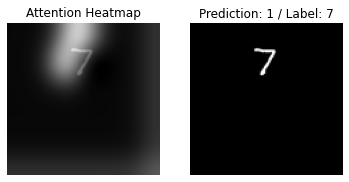

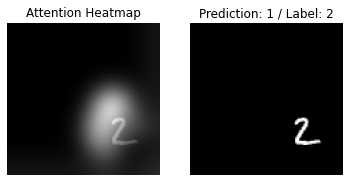

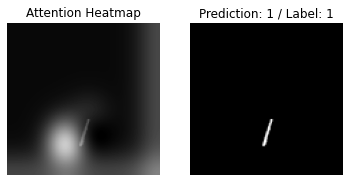

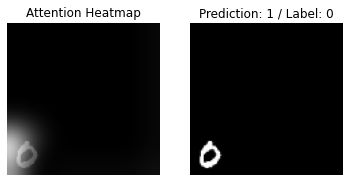

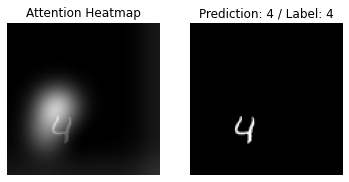

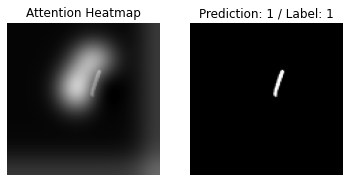

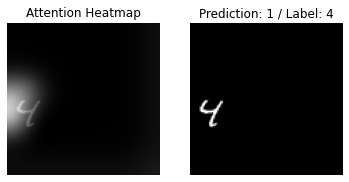

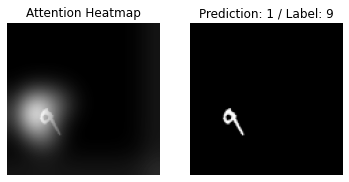

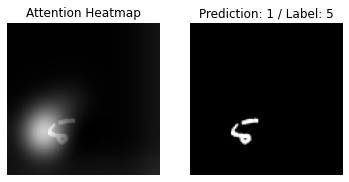

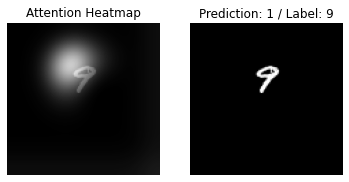

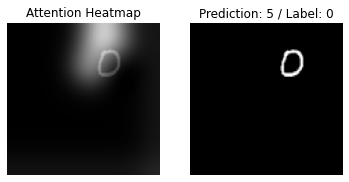

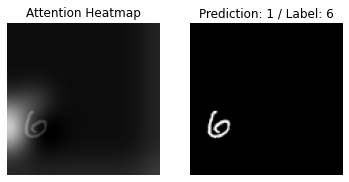

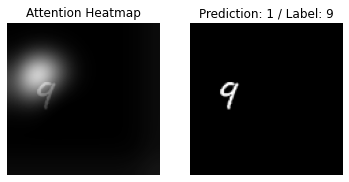

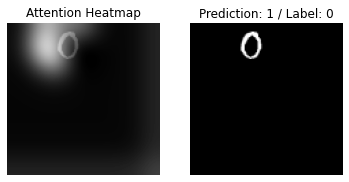

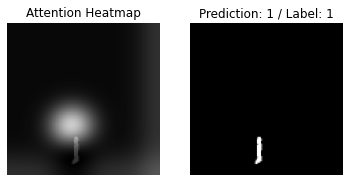

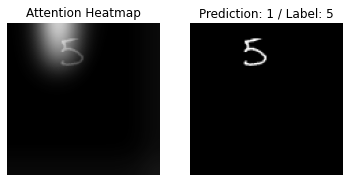

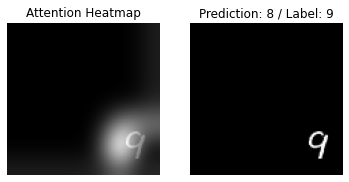

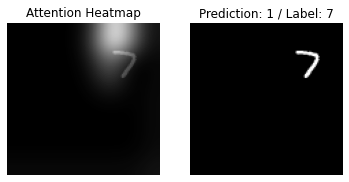

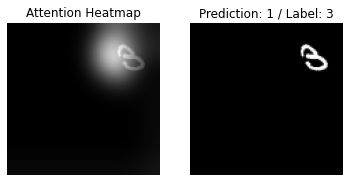

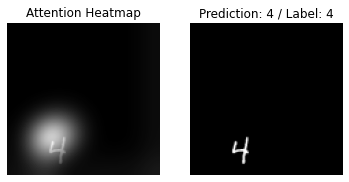

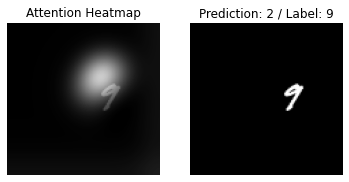

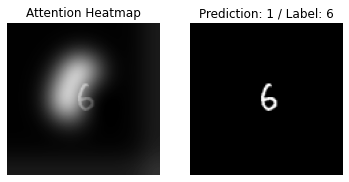

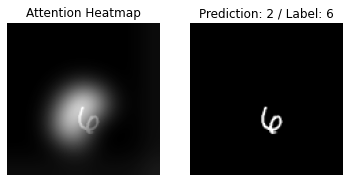

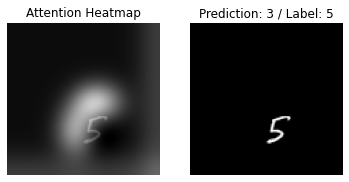

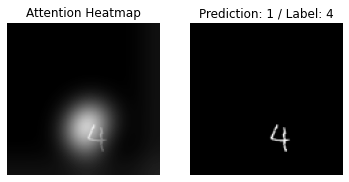

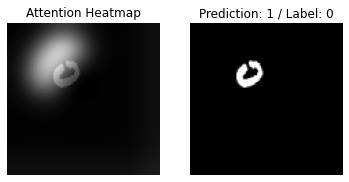

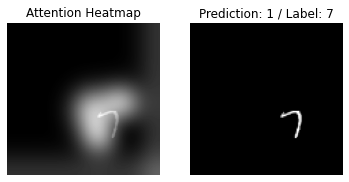

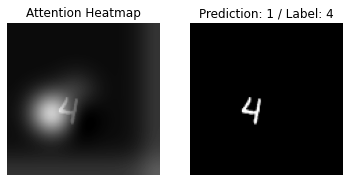

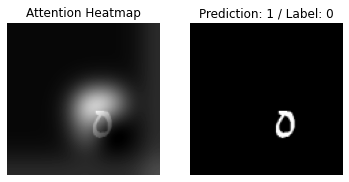

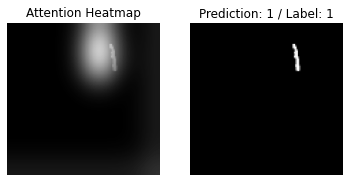

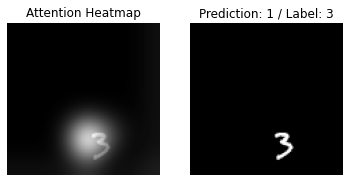

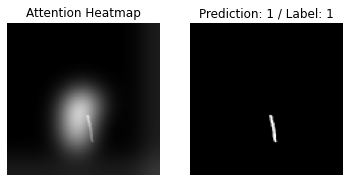

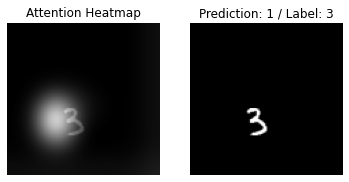

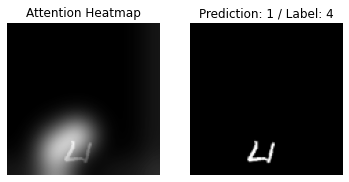

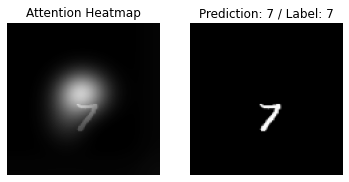

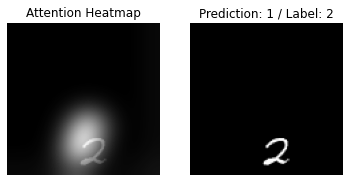

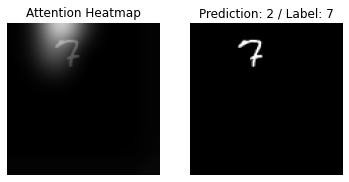

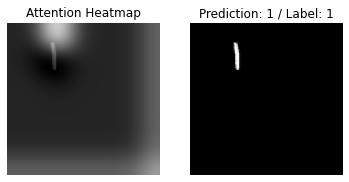

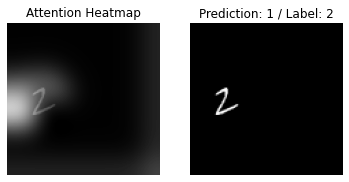

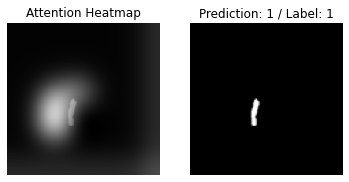

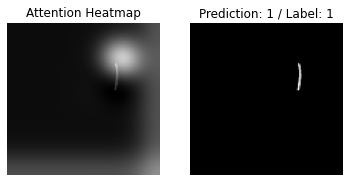

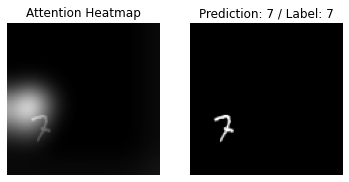

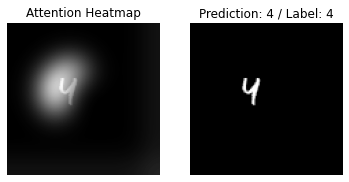

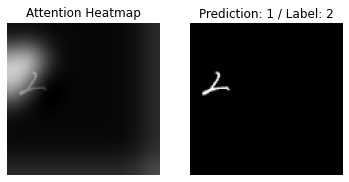

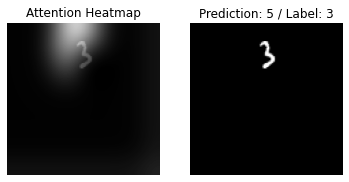

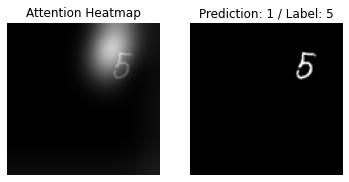

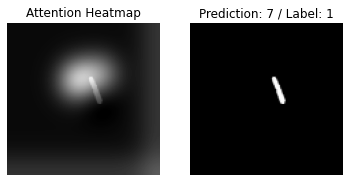

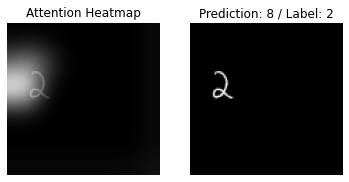

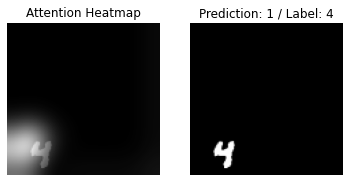

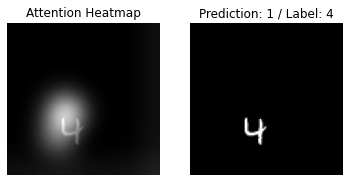

Sample Accuracy: 0.26


In [14]:
# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 1])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
    test_x_in = test_x_reshape[idx_sample,:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx_sample,:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)
    alpha_resize = cv2.resize(alpha_resize, dsize=(img_size,img_size), interpolation=cv2.INTER_LINEAR)
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx_sample, :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(test_x[idx_sample,:,:], cmap='gray')
    i = ax[0].imshow(alpha_resize,cmap="gray", alpha=0.8)
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    
    ax[1].imshow(test_x[idx_sample,:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))